In [1]:
import polars as pl
from datetime import date,datetime
import matplotlib.pyplot as plt

In [2]:
# read in all csv files with polars
city_features_df = pl.read_csv('./city_cgm_plus_features.csv')
dclp3_features_df = pl.read_csv('./dclp3_cgm_plus_features.csv')
dclp5_features_df = pl.read_csv('./dclp5_cgm_plus_features.csv')
flair_features_df = pl.read_csv('./flair_cgm_plus_features.csv')
hall18_features_df = pl.read_csv('./hall18_cgm_plus_features.csv')
mdex_features_df = pl.read_csv('./mdex_cgm_plus_features.csv')
ndiab_features_df = pl.read_csv('./ndiab_cgm_plus_features.csv')
repbg_features_df = pl.read_csv('./repbg_cgm_plus_features.csv')
rtcgm_features_df = pl.read_csv('./rtcgm_cgm_plus_features.csv')
sence_features_df = pl.read_csv('./sence_cgm_plus_features.csv')
sevhypo_features_df = pl.read_csv('./sevhypo_cgm_plus_features.csv')
wisdm_features_df = pl.read_csv('./wisdm_cgm_plus_features.csv')

city_demo_df = pl.read_csv('./city_demographic_data.csv')
dclp3_demo_df = pl.read_csv('./dclp3_demographic_data.csv')
dclp5_demo_df = pl.read_csv('./dclp5_demographic_data.csv')
flair_demo_df = pl.read_csv('./flair_demographic_data.csv')
hall18_demo_df = pl.read_csv('./hall18_demographic_data.csv')
mdex_demo_df = pl.read_csv('./mdex_demographic_data.csv')
repbg_demo_df = pl.read_csv('./repbg_demographic_data.csv')
rtcgm_demo_df = pl.read_csv('./rtcgm_demographic_data.csv')
sence_demo_df = pl.read_csv('./sence_demographic_data.csv')
sevhypo_demo_df = pl.read_csv('./sevhypo_demographic_data.csv')
wisdm_demo_df = pl.read_csv('./wisdm_demographic_data.csv')

In [3]:
city_df = city_features_df.join(city_demo_df, on="SID", how="left")
dclp3_df = dclp3_features_df.join(dclp3_demo_df, on="SID",how="left")
dclp5_df = dclp5_features_df.join(dclp5_demo_df, on="SID",how="left")
flair_df = flair_features_df.join(flair_demo_df, on="SID",how="left")
hall18_df = hall18_features_df.join(hall18_demo_df, on="SID", how="left")
mdex_df = mdex_features_df.join(mdex_demo_df, on="SID", how="left")
repbg_df = repbg_features_df.join(repbg_demo_df, on="SID", how="left")
rtcgm_df = rtcgm_features_df.join(rtcgm_demo_df, on="SID", how="left")
sence_df = sence_features_df.join(sence_demo_df, on="SID", how="left")
sevhypo_df = sevhypo_features_df.join(sevhypo_demo_df, on="SID", how="left")
wisdm_df = wisdm_features_df.join(wisdm_demo_df, on="SID", how="left")

In [4]:
hall18_df = hall18_df.with_columns(pl.col("Age").cast(pl.Int64))
sevhypo_df = sevhypo_df.with_columns(pl.col("Age").fill_null(-1).cast(pl.Int64))

In [5]:
# create a list of the dataframes excluding city and dclp3 dataframe to vstack
df_list = [dclp5_df ,flair_df ,hall18_df ,mdex_df ,repbg_df ,rtcgm_df ,sence_df ,sevhypo_df ,wisdm_df]

# vstack city and dclp3 dataframe
combined_df = city_df.vstack(dclp3_df)

# iterate through and add the remaining 10 datasets to the combined df
for i in df_list:
    combined_df = combined_df.vstack(i)

In [6]:
# create the date and date_time columns
combined_df = combined_df.with_columns(combined_df['Date'].str.replace(r'\.0+', '').alias('Date'))
combined_df = combined_df.with_columns(pl.col('Date').str.to_datetime('%Y-%m-%d %H:%M:%S').alias('Date'))
combined_df = combined_df.with_columns(combined_df['Date_Time'].str.replace(r'\.[0-9]+', '').alias('Date_Time'))
combined_df = combined_df.with_columns(pl.col('Date_Time').str.to_datetime('%Y-%m-%d %H:%M:%S').alias('Date_Time'))

In [7]:
# Select Data for EDA Analysis
EDA_data = combined_df.select('SID','Day','Hour','Min'
                              ,'DT_Index','DailyTI_Index'
                              ,'StudyTI_Index','BMI','BMI_Class'
                              ,'Tx_Modality', 'Race', 'Sex','Age'
                              , 'Value')
EDA_data.write_csv('./CGM_EDA_data.csv')

In [8]:
# get the unique number of patients
len(combined_df['SID'].unique())

1826

In [9]:
# group by patient id and day and get the count of readings per day
daily_id_counts = combined_df.group_by(['SID', 'Day']).agg(pl.col('DT_Index').count().alias('DT_Index_Count'))

In [10]:
# sort by paitent ID and day
daily_id_counts = daily_id_counts.sort(['SID', 'Day'])

In [11]:
# Filter to the number of patient days with 288 readings (reading every 5 minutes)
complete_days = daily_id_counts.filter(pl.col('DT_Index_Count') >= 288)

# Print number of days
len(complete_days)

101168

In [12]:
# create the SID_Day key to join to data to filter out records not a part of complete days
complete_days = complete_days.with_columns(
    pl.concat_str(
        [
            pl.col("SID"),
            pl.col("Day"),
        ],
        separator=" ",
    ).alias("SID_Day"),
)

In [13]:
# number of complete days of readings each patient has
complete_days.group_by(['SID']).agg(pl.col('Day').count().alias('Complete_Days'))

SID,Complete_Days
str,u32
"""DCLP5-79""",74
"""DCLP3-005-005""",134
"""WISDM-182""",122
"""REPBG-116""",188
"""SENCE-61""",88
"""DCLP3-002-021""",112
"""WISDM-129""",114
"""RTCGM-186""",22
"""SEVHYPO-23""",1


In [14]:
# create the SID_Day key to join to data to filter out records not a part of complete days
combined_df = combined_df.with_columns(
    pl.concat_str(
        [
            pl.col("SID"),
            pl.col("Day"),
        ],
        separator=" ",
    ).alias("SID_Day"),
)

In [15]:
# inner join the complete days with all records to create dataset we will use for model building and eval
records_kept = combined_df.join(complete_days, on = 'SID_Day', how = 'inner')
records_kept.head(1)

SID,Date_Time,Date,Day,Hour,Min,DT_Index,DailyTI_Index,StudyTI_Index,Value,Study,Age,Sex,Race,BMI,BMI_Class,Baseline_HbA1c,Tx_Modality,Diabetes_Type,SID_Day,SID_right,Day_right,DT_Index_Count
str,datetime[μs],datetime[μs],i64,i64,i64,str,i64,i64,f64,str,i64,str,str,f64,str,f64,str,str,str,str,i64,u32
"""CITY-1""",2000-03-26 00:04:54,2000-03-26 00:00:00,1,0,4,"""2000-03-26 00:…",0,288,234.0,"""CITY""",18,"""F""","""White""",23.187635,"""Normalweight""",8.2,"""MDI""","""T1D""","""CITY-1 1""","""CITY-1""",1,288


In [16]:
# check that the number of complete days is the same as the number of unique days in records kept
len(complete_days)==len(records_kept["SID_Day"].unique())

True

In [30]:
len(records_kept["SID_Day"].unique())

101168

In [17]:
# Export data for modeling
export_data = records_kept.select('SID','Day','Hour','Min','DT_Index','DailyTI_Index','StudyTI_Index','BMI','BMI_Class','Tx_Modality','Value')
export_data.write_csv('./CGM_model_data.csv')

### Profiling Missingness

In [18]:
# sort dataframe by SID and Date_Time
combined_df = combined_df.sort(['SID', 'Date_Time'])

# create a previous missing readings column
df = combined_df.with_columns(
    pl.when(combined_df['SID'] == combined_df['SID'].shift(1))
        .then(combined_df['StudyTI_Index'] - combined_df['StudyTI_Index'].shift(1)-1)
        .otherwise(None).alias('previous_missing_readings')
)

# make any missing more than 1000 readings be 1000
df = df.with_columns(
    pl.when(df['previous_missing_readings'] >1000)
        .then(1000)
        .otherwise(df['previous_missing_readings']).alias('previous_missing_readings')
)

In [19]:
# Number of days missing 1 or 2 readings
len(df.filter((pl.col('previous_missing_readings')==1) | (pl.col('previous_missing_readings')==2)))

3004598

Text(0.5, 1.0, 'Histogram of previous_missing_readings')

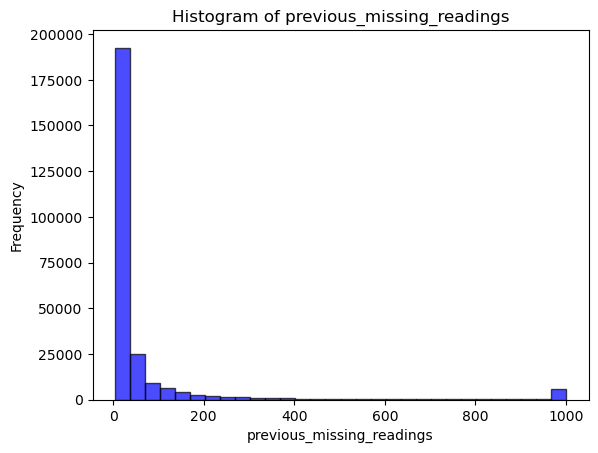

In [20]:
# Missing readings are defined as more than 3 missing readings for the project
missing_readings = df.filter(pl.col('previous_missing_readings') > 3)

# create data for a histogram by converting to Numpy
hist_data = missing_readings['previous_missing_readings'].to_numpy()

# Plot a histogram using matplotlib
plt.hist(hist_data, bins=30, alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('previous_missing_readings')
plt.ylabel('Frequency')
plt.title('Histogram of previous_missing_readings')

In [21]:
# Calculate the percentage of readings missing each count
pct_missing_reads = missing_readings.group_by('previous_missing_readings').agg(pl.col('previous_missing_readings').count().alias('Count')).select(
        pl.col('previous_missing_readings'),
        (pl.col('Count') / len(missing_readings)).alias('Percent')*100
    )

In [22]:
# Look at the readings missing less than 8 hours of data
missing_pct_interest = pct_missing_reads.filter(pl.col('previous_missing_readings') <= 96).sort('previous_missing_readings')

In [23]:
# Calculate the percentage each group is missing from 4 to 96 to Generate distribution for test set
missing_pct_interest = missing_pct_interest.select(pl.col('previous_missing_readings'),
                                                   (pl.col('Percent') / missing_pct_interest['Percent'].sum()).alias('Test_Weight')*100
    )

In [24]:
# Ensure sums to 100
missing_pct_interest['Test_Weight'].sum()

100.00000000000006

In [27]:
# View table
missing_pct_interest.write_csv('./test_weights.csv')